## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, I am working to understand the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability



In [1]:
#import all dependencies
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df_ab_data = pd.read_csv('ab_data.csv')
df_ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
#find number of rows in data
ab_rows = df_ab_data.shape
#display number of rows
print(f'there are {ab_rows[0]} in dataset')

there are 294478 in dataset


c. The number of unique users in the dataset.

In [4]:
#number of unique users
unique_users = df_ab_data['user_id'].nunique()
# display number of unique users
print(f'There are {unique_users} unique users')


There are 290584 unique users


d. The proportion of users converted.

In [5]:
#proportion of users converted
prop_convert = df_ab_data.query('converted == True').count()/df_ab_data.shape[0]
#display proporotion of users converted
print(f'the proportion of users converted is: {prop_convert[0]:.6f} or{round(prop_convert[0],2):.2%}')

the proportion of users converted is: 0.119659 or12.00%


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#seeing how many times control and treatment group don't line up with appropriate landing_page for testing
landing_pages = df_ab_data.groupby('group')['landing_page'].value_counts()
landing_pages


group      landing_page
control    old_page        145274
           new_page          1928
treatment  new_page        145311
           old_page          1965
Name: landing_page, dtype: int64

**new_page is also showing up under the control group.   need to add that to old_page that shows up under
treatment to get total**

In [7]:
#number of times new-page and treatment are not lined up
# add new_page from control group with old_page under treatment group
total_no_match = landing_pages[1] + landing_pages[3]
print(f'number of times new_page and treatment are not lined up is: {total_no_match}')

number of times new_page and treatment are not lined up is: 3893


f. Do any of the rows have missing values?

In [8]:
#check for missing values in any rows
df_ab_data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [10]:
#create new dataframe removing rows that are not aligned with treatment and new page
# this means removing all rows where group is control and new_page   and treatment and old_page
df2=df_ab_data.query( '(group == "treatment" & landing_page == "new_page" )or (group == "control" & landing_page == "old_page")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [12]:
#check number of unique user_ids
df2_unique = df2['user_id'].nunique()
#display
print(f'there are {df2_unique} unique user_ids')

there are 290584 unique user_ids


b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
#get the one user_id that is repeated
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

**we can see user_id 773192 is repeated - both are NOT converted so doesn't matter which one to drop**

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#drop duplicate user_id using the index 2893
df2.drop([2893],inplace=True)

C:\Users\howar\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
#verify dropped row was successful
df2.duplicated().sum()

0

In [16]:
#probability of converting regardless of page received
convert = df2.query('converted == 1').count()/df2.shape[0]
#display
print(f'probablity of individual converting regarless of page they recieve is: {convert[0]:.4f}')

probablity of individual converting regarless of page they recieve is: 0.1196


b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
# probability converted if in control group
control_convert = df2.query('group == "control" & converted == 1').count()[0]/df2.query('group == "control"').count()[0]
#display
print(f'probablity individual in control group converted is {control_convert:.4f}')

probablity individual in control group converted is 0.1204


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#probability converted if in  treatment group
treat_convert = df2.query('group == "treatment" & converted == 1').count()[0]/df2.query('group == "treatment"').count()[0]
#display
print(f'probablity individual in treatment group converted is {treat_convert:.4f}')

probablity individual in treatment group converted is 0.1188


**below is cleaner but wanted to code it out**

In [19]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
#probability received new page
new_page_prob = df2.query('landing_page == "new_page"').count()/df2.shape[0]
#display
print(f'probability an individual received a new page is: {new_page_prob[0]:.4f}')

probability an individual received a new page is: 0.5001


**Based on the timestamps it appears this test went on for 3 weeks, which should be enough time for individuals testing and getting appropriate results**<br>
* The probability of converting regardless of the page received is 12%.  That number is an incredible conversion rate, and it appears it stays at 12% either with old page or new page
* If the individual is in the control group or the treatment group didn't seem to matter
* Since 50% of the people received the treatment page the test was a fair test.
<br>

**Was there change aversion?  Could be, hard to tell.  I would recommend client run test one more time to see if results are same or similar.**  <br>
**There is clear evidence from this run that the treatment page does NOT lead to more conversions.  But, what about revenue? We don't know if the products are the same.  If the products on the treatment page have a higher markup then we compare the revenue and the treatment page would be something to consider, if products are the same meaning revenue is same then it would not make sense to change the landing page.**


## <a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null:  p_new <= p_old**<br>
**ALternative: p_new > p_old (prove new landing page converts better)**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
#calculate convert rate for p_new under the null. since there is no change in conve
p_new = df2.converted.mean()
print(f'the convert rate for p_new under the null: {p_new:.4f}')

the convert rate for p_new under the null: 0.1196


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
#the convert rate for p_old is the same as for p_new as the success rates are equal regardless of page
p_old = df2.converted.mean()
print(f'the convert rate for p_old under the null: {p_old:.4f}')

the convert rate for p_old under the null: 0.1196


c. What is $n_{new}$?

In [23]:
#calculate number of new pages
pages_new = df2['landing_page'].value_counts()[0]
print(f'n_new is: {pages_new}')

n_new is: 145310


d. What is $n_{old}$?

In [24]:
#calculate number of old pages
pages_old = df2['landing_page'].value_counts()[1]
#display number of old pages
print(f'n_old is: {pages_old}')

n_old is: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
# for the number of new pages store either 1 or 0 .  run test 145,310 which is the number of new pages using the probablity
# of .1196 and 1 - .1196.  We need both probabilities as the size in a [0,1] needs to match the size in p
new_page_converted = np.random.choice([0,1], pages_new,replace=True,p=[p_new, 1 - p_new])


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
# for the number of old pages store either 1 or 0 .  run test 145,274 which is the number of old pages using the probablity
# of .1196 and 1 - .1196.  We need both probabilities as the size in a [0,1] needs to match the size in p.  The difference
#in page sizes is insignificant.

old_page_converted = np.random.choice([0,1],pages_old,replace=True,p=[p_old, 1 - p_old])


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
#we now need to take the mean for the old and new pages converted and get the difference
simulated_page_mean = new_page_converted.mean() - old_page_converted.mean()
print(f'the simulated mean is: {simulated_page_mean:.4f}')

the simulated mean is: 0.0001


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
#simulate 10,000 p_new - p_old values.  Storing all values in the numpy array p_diffs
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], pages_new,replace=True,p=[p_new, 1 - p_new]).mean()
    old_page_converted = np.random.choice([0,1],pages_old,replace=True,p=[p_old, 1 - p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)
    
print('loop finished')
#convert p_diff to a numpy array for plotting histogram
p_diffs = np.array(p_diffs)
    

loop finished


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  

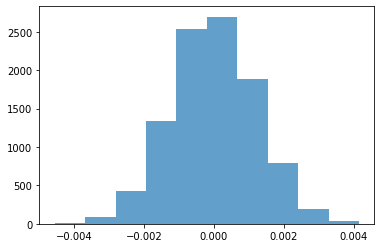

In [29]:
#plot a histogram of the difference in means - this shows that the left tail is alittle larger than right
#meaning there was a slight difference with the old page converting more.
plt.hist(p_diffs,alpha=.7);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
#calculate the actual difference from the control and treatment which is p_new - p_old.
actual_diffs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diff_prop=(p_diffs > actual_diffs).mean()
print(f'the proportion of the p_diffs greater than actual difference in the data: {actual_diff_prop}')                        
                         

the proportion of the p_diffs greater than actual difference in the data: 0.9045


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I subtracted the mean of the control group that converted from the mean of the treatment group that converted. My null hypothesis was p_new <= p_old.  This was a negative number so the null is true.  The value 0.9047 is the p-value and since its a large p-value (> 0.05) - in fact significantly greater this indicates weak evidence against the null.  So, we fail to reject the null hypothesis and keep the old landing page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [43]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted ==1').count()[0]
convert_new = df2.query('landing_page == "new_page" & converted ==1').count()[0]
n_old = df2['landing_page'].value_counts()[1]
n_new = df2['landing_page'].value_counts()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [44]:
z_score, p_val = sm.stats.proportions_ztest([convert_new, convert_old],[n_new,n_old],alternative='larger')
print(f'z_score is: {z_score:.4f}')
print(f'p_value is: {p_val:.4f}')

z_score is: -1.3109
p_value is: 0.9051


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z_score is low so we fail to reject the null hypothesis.  The p_value which is equal to the p_value from part j which is good.  Since the p_value is large we fail to reject the null hypothesis.  My findings for the z_score and p_value using the statsmodel proportions agree with the findings in parts j and k and we fail to reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I will  be using logistic regression since its categorical - only two outcomes, did the page convert or not**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [55]:
#setting up the intercept and the dummy variables for group and landing_page
df2['intercept']=1

df2['ab_page']=pd.get_dummies(df2.group,drop_first=True)

C:\Users\howar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\howar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [58]:
#instantiate the model then fit and show summary stats
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']]).fit()
model.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-04-30 09:58 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**The p-value associated with the ab_page is 0.1899.  The difference in p-values come down to the following:
is it a one-sided tail vs a two-sided tail.  I set up the alternative hypothesis as p_new > p_old, therefore that
is a one sided tail.  Only looking to see if the p_new will be greater than the p_old(no other direction) On the other hand, the logistic model is a two tailed test. coefficient looking at not = 0, tails going in both directions<br>**
<br>**NOTE- I am wondering if we need to exponentiate the coefficients???**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Additional predictor variables will usually improve the model. Additional variables will bring new coefficients that will vary to get a better fit for the model.  But you have to be careful.The additional variable can't be correlated. There can be possible side effect with multicollinearity- meaning multiple variables are correlated.  This can lead to inaccurate hypothesis testing**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns -  Provide the statistical output as well as a written response to answer this question.

In [65]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [68]:
#confirm new dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,treatment,control,ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [69]:
#lets see how many different countries are in df 
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [70]:
### Create the necessary dummy variables
# I am creating two dummy variables for the dataframe by dropping CA
df_new[['US','UK',]]=pd.get_dummies(df_new.country,drop_first=True)



In [71]:
#verify
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,treatment,control,ab_page,US,UK
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1,0,1


In [73]:
#instantiate the model then fit and show summary stats
df_new['intercept']=1
model_country = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK']]).fit()
model_country.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-04-30 16:31 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
UK             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**It does appear country had  a difference of  impact on conversion as the coefficients are different as well 
as the distance from the mean.  Both countries p-values are suggesting there is weak evidence against the
null hypothesis.  However, the p-value in the UK is .05 higher than p-value in US.  This is why we can do
an interaction as stated below**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [75]:
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,treatment,control,ab_page,US,UK
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,1,0


In [76]:
### Fit Your Linear Model And Obtain the Results
#setup the interaction between country and ab_page
df_new['US_page']=df_new['US']*df_new['ab_page']
df_new['UK_page']=df_new['UK']*df_new['ab_page']
#instantiate and fit model
model_country_page = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK','US_page','UK_page']]).fit()
model_country_page.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-04-30 17:21 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
UK             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
US_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
UK_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

<a id='conclusions'></a>
## Conclusions

Every model has reached the same conclusion.  The p-values were all > .05 indicating there is weak evidence against the null hypothesis suggesting the old landing page will remain.  There might be other issues to look at however.  Does the new landing page have the same functionality but only different in design.  Does new landing page have different funcionality?  Are there new products on new landing page?  Was there aversion to change?   Was this test based on revenue or just clicks?


